# Hopper Data Science Puzzle

### This puzzle was featured on a few data-related job postings at Hopper. The "puzzle" consists of a mysterious dataset (1024 2-dimensional datapoints) and the task is to extract any possible insight.

We start by pulling it into Pandas and running a quick plot.

In [38]:
import pandas as pd

In [39]:
df = pd.read_csv('puzzle.csv', names=['A', 'B'])
df.head()

,A,B
0,0.39715,2.113629
1,0.39715,2.113629
2,0.39715,2.113629
3,0.39715,2.113629
4,0.39715,2.113629


<AxesSubplot:xlabel='A', ylabel='B'>

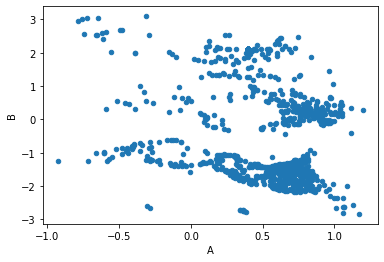

In [40]:
df.plot.scatter(x='A', y='B')

Nothing really obvious here. The datapoints are definitely not random - maybe we'll see something if we invert the axes.

<AxesSubplot:xlabel='B', ylabel='A'>

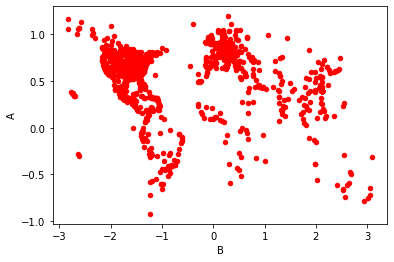

In [41]:
df.plot.scatter(x='B', y='A', c='red')

Looks like the world map, doesn't it? Based off of the density of points in North America and the scarcity in regions like Russia and Africa, it seems reasonable to assume that these points represent the locations of airports worldwide.

However, geospatial locations are usually represented as longitude and latitude, not these arbitrary units we're seeing here. It would be nice if we could come up with functions linking these units to long/lat. Luckily, we can do that. If we assume that longitude is a linear function of A and latitude is a linear function of B, we just need 2 anchor points to solve the functions.

<AxesSubplot:>

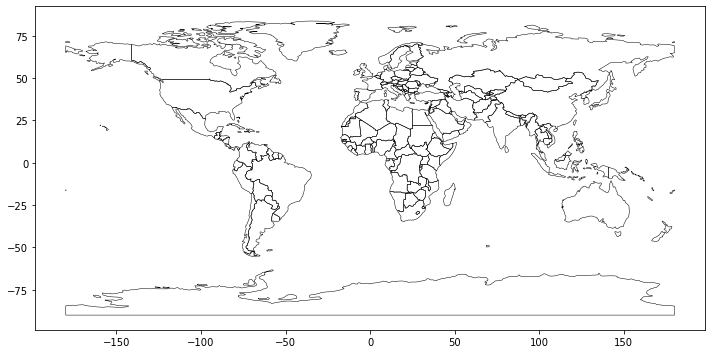

In [42]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.boundary.plot(color='black', linewidth=0.5, figsize=(12,12))


We need to choose 2 points in the original dataset and make assumptions as to which airports they represent. From there, we can research the actual long/lat co-ordinates of those airports, and solve our linear equations. The 2 points I'm going to pick are:

- southernmost datapoint in South America - let's assume this is Punta Arenas, Chile
- southernost datapoint in Africa - lets assume this is Cape Town, South Africa

Running a quick Google search, we see that the co-ordinates of Presidente Carlos Ibáñez del Campo International Airport in Punta Arenas are 53.0052° S, 70.8428° W, and the co-ordinates of Cape Town International Airport are 33.9715° S, 18.6021° E.

Now, we need the A/B co-ordinates of those 2 airports in our original dataset. Let's start with Chile.

In [43]:
# Finding the A/B co-ords of the Punta Arenas airport.
df[(df['A'] < -0.85) & (df['B'] < -1)]

,A,B
970,-0.92507,-1.236646


In [44]:
# Finding the A/B co-ords of the Cape Town airport.
df[(df['A'] < -0.5) & (0 < df['B']) & (df['B'] < 1)]

,A,B
472,-0.592798,0.324661
809,-0.516870,0.543142


For Cape Town, we pick the southernmost point from the area we filtered, so (-0.592798, 0.324661).

Ok, so let's first solve the longitude equation.

$long = \alpha A + \beta$

Punta Arenas: $-53.0052 = \alpha(-0.92507) + \beta$ <br>
Cape Town: $-33.9715 = \alpha(-0.592798) + \beta$

2 equations, 2 variables, we solve to get $\alpha = 57.283491, \beta = -.013961$

Next up, latitude.

$lat = \gamma B + \delta$

Punta Arenas: $-70.8428 = \gamma(-1.236646) + \delta$ <br>
Cape Town: $18.6021 = \gamma(0.324661) + \delta$

We obtain $\gamma = 57.288477, \delta = 0.002766$

Our offset values here are really small, and it's likely that the true functions don't involve any actual shifts, just scalar transformations - but I'm going to keep them (they're virtually negligible anyway).

Let's add these transformations to our original dataset.

In [45]:
df['Longitude'] = df['A'].map(lambda x : 57.283491*x - 0.013961)
df['Latitude'] = df['B'].map(lambda x : 57.288477*x + 0.002766)

df.head()

,A,B,Longitude,Latitude
0,0.39715,2.113629,22.73616,121.089329
1,0.39715,2.113629,22.73616,121.089329
2,0.39715,2.113629,22.73616,121.089329
3,0.39715,2.113629,22.73616,121.089329
4,0.39715,2.113629,22.73616,121.089329


Let's put this on the map.

<AxesSubplot:xlabel='Latitude', ylabel='Longitude'>

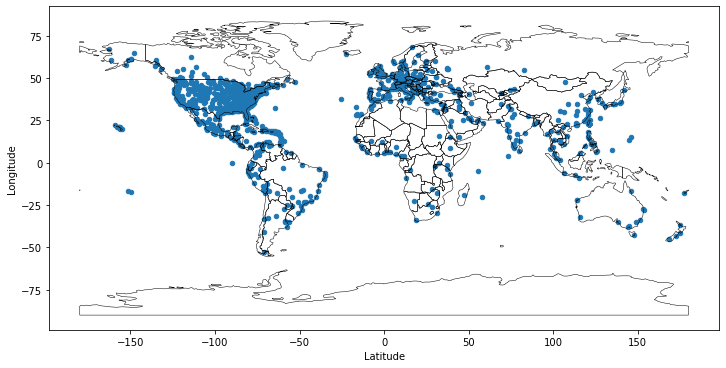

In [46]:
base = world.boundary.plot(color='black', linewidth=0.5, figsize=(12,12))
df.plot.scatter(x='Latitude', y='Longitude', ax=base)

Bingo! Looks good to me. It's interesting just how dense airports are in North America and Europe compared to the rest of the world.